## Homework
- In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from here - https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
- In this dataset our desired target for classification task will be converted variable - has the client signed up to the platform or not.

In [12]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score

from collections import Counter
from tqdm.auto import tqdm

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv -O course_lead_scoring.csv

--2025-10-21 16:41:51--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.01s   

2025-10-21 16:41:52 (6.67 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



## Data preparation

### Loading Data

In [3]:
# load the data
df = pd.read_csv('course_lead_scoring.csv')
df.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [4]:
# print the data types and column names
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

Data has
- 9 columns in total are there
- 4 object columns (`lead_source`, `industry`, `employment_status`, `location`)
- 4 numeric columns (`number_of_courses_viewed`, `annual_income`, `interaction_count`, `lead_score`)
- `converted` is the target variable

In [5]:
# df shape
df.shape

(1462, 9)

- Data has 1462 rows and 9 columns

### Handling missing values
If there are missing values:
- For categorical features, replace them with 'NA'
- For numerical features, replace with with 0.0


In [6]:
# Check if the missing values are presented in the features.
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Following columns have missing values:
- 'lead_source' - 128 missing values
- 'industry' - 134 missing values
- 'annual_income' - 181 missing values
- 'employment_status' - 100 missing values
- 'location' - 63 missing values

In [7]:
category_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# For all categorical features, replace them with 'NA', as they all have null values
df[category_columns] = df[category_columns].fillna('NA')

# Only annual_income numerical column has null values, hence replacing nulls with 0.0
df['annual_income'] = df['annual_income'].fillna(0)

In [8]:
# verify null values are handled
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [9]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

del df_train['converted']
del df_val['converted']
del df_test['converted']

# print the shapes of the resulting dataframes
print("df_train shape:", df_train.shape)
print("df_val shape:", df_val.shape)
print("df_test shape:", df_test.shape)

# print the shapes of the y datasets
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

df_train shape: (876, 8)
df_val shape: (293, 8)
df_test shape: (293, 8)
y_train shape: (876,)
y_val shape: (293,)
y_test shape: (293,)


## Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable.
You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [10]:
auc_scores = {}
for numerical_column in numerical_columns:
    auc_score = roc_auc_score(y_train, df_train[numerical_column])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[numerical_column])
    auc_scores[numerical_column] = auc_score

highest_auc_variable = max(auc_scores, key=auc_scores.get)
highest_auc_value = auc_scores[highest_auc_variable]
print(f"The numerical variable with the highest AUC is '{highest_auc_variable}' with an AUC of {highest_auc_value:.4f}")

The numerical variable with the highest AUC is 'number_of_courses_viewed' with an AUC of 0.7636


## Question 2: Training the model

In [13]:
scaler = StandardScaler()
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()

df_train_scaled[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
df_val_scaled[numerical_columns] = scaler.transform(df_val[numerical_columns])

dv = DictVectorizer(sparse=False)

train_dict = df_train_scaled[numerical_columns + category_columns].to_dict(orient='records')
val_dict = df_val_scaled[numerical_columns + category_columns].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auc_score = auc(fpr, tpr)
print(f"AUC on validation set: {auc_score:.3f}")

AUC on validation set: 0.921


## Question 3: Precision and Recall

In [14]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# for all thresholds, calculate tp, fp, fn, tn
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        # Skip this threshold if we can't calculate precision or recall
        if (tp + fp) == 0 or (tp + fn) == 0:
            continue

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        scores.append((t, tp, fp, fn, tn, precision, recall))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

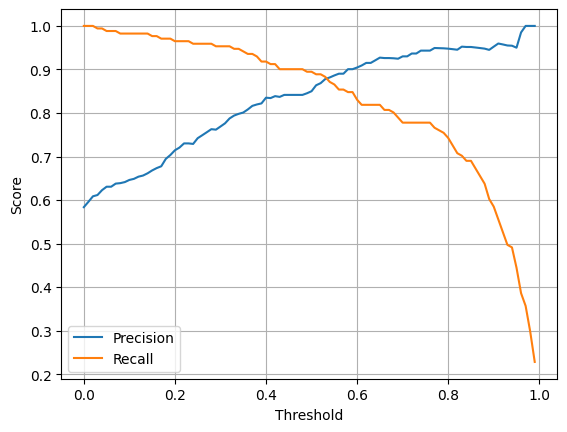

Answer : Precision:  0.878 and Recall:  0.883 are intersecting at threshold: 0.530


In [15]:
df_scores = tpr_fpr_dataframe(y_val, y_val_pred)

# Plot precision and recall computed for all thresholds in df_scores
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
df_scores['diff'] = np.abs(df_scores['precision'] - df_scores['recall'])
intersection_idx = df_scores['diff'].idxmin()
intersection_threshold = df_scores.loc[intersection_idx, 'threshold']

# value of precision and recall at the intersection point
precision = df_scores.loc[intersection_idx, 'precision']
recall = df_scores.loc[intersection_idx, 'recall']

# print threshold where precision and recall intersect with 3 decimals
print(f"Answer : Precision: {precision: .3f} and Recall: {recall: .3f} are intersecting at threshold: {intersection_threshold:.3f}")

## Question 4: F1 score

In [16]:
# Precision and recall are conflicting - when one grows, the other goes down.
# That's why they are often combined into the F1 score - a metrics that takes into account both
# This is the formula for computing F1:
# F1 = 2 * (precision * recall) / (precision + recall)
# Where P is precision and R is recall.
# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01. At which threshold F1 is maximal?
df_scores['f1'] = df_scores.apply(
    lambda row: 0 if (row['precision'] + row['recall']) == 0
    else 2 * (row['precision'] * row['recall']) / (row['precision'] + row['recall']),
    axis=1
)
max_f1_idx = df_scores['f1'].idxmax()
max_f1_threshold = df_scores.loc[max_f1_idx, 'threshold']
max_f1_value = df_scores.loc[max_f1_idx, 'f1']
print(f"Answer : Maximum F1 score of {max_f1_value:.4f} occurs at threshold: {max_f1_threshold}")


Answer : Maximum F1 score of 0.8805 occurs at threshold: 0.53


## Question 5: 5-Fold CV

In [30]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx].copy()
    df_val = df_full_train.iloc[val_idx].copy()

    y_train = df_train.pop('converted')
    y_val = df_val.pop('converted')

    scaler = StandardScaler()
    df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
    df_val[numerical_columns] = scaler.transform(df_val[numerical_columns])

    dv = DictVectorizer(sparse=False)
    train_dict = df_train[numerical_columns + category_columns].to_dict(orient='records')
    val_dict = df_val[numerical_columns + category_columns].to_dict(orient='records')

    X_train = dv.fit_transform(train_dict)
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"C={C}  AUC: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

C=1.0  AUC: 0.921 ± 0.010


## Question 6: Hyperparameter Tuning

In [32]:
# Now let's use 5-Fold cross-validation to find the best parameter C
# Iterate over the following C values: [0.000001, 0.001, 1]
# Initialize KFold with the same parameters as previously
# Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
# Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
C_values = [0.000001, 0.001, 1]
best_C = None
best_mean_auc = 0
best_std_auc = 0
for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx].copy()
        df_val = df_full_train.iloc[val_idx].copy()

        y_train = df_train.pop('converted')
        y_val = df_val.pop('converted')

        scaler = StandardScaler()
        df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
        df_val[numerical_columns] = scaler.transform(df_val[numerical_columns])

        dv = DictVectorizer(sparse=False)
        train_dict = df_train[numerical_columns + category_columns].to_dict(orient='records')
        val_dict = df_val[numerical_columns + category_columns].to_dict(orient='records')

        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_auc = np.std(scores)

    print(f"C={C}  AUC: {mean_auc:.3f} ± {std_auc:.3f}")

    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_C = C

# Which C leads to the best mean score?
print(f"Best C: {best_C} with AUC: {best_mean_auc:.3f} ± {best_std_auc:.3f}")

C=1e-06  AUC: 0.903 ± 0.013
C=0.001  AUC: 0.905 ± 0.013
C=1  AUC: 0.921 ± 0.010
Best C: 1 with AUC: 0.921 ± 0.010
